# Loading necessary libraries

In [42]:
import sys, importlib
from pathlib import Path

# Core data analysis imports
import numpy as np
import re  # Importing re for regex operations
import pandas as pd
import scipy.stats
from scipy.stats import gaussian_kde

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Setup imports
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Force reload all modules
modules = ['iowa_dream.data', 'iowa_dream.data.importer', 
          'iowa_dream.data.loader', 'iowa_dream.utils.plotting',
          'iowa_dream.utils.describer', 'iowa_dream.data.cleaner', 
          'iowa_dream.utils.inconsistency_check']

for m in modules:
    if m in sys.modules:
        importlib.reload(sys.modules[m])
    else:
        __import__(m)

from iowa_dream.data.importer import load_config
from iowa_dream.data.loader import preliminary_loader, standardize_column_names
from iowa_dream.utils.describer import categorical_describer, numerical_describer
from iowa_dream.utils.plotting import plot_missing_data_heatmap, box_plot_dist
from iowa_dream.data.cleaner import simple_fill_missing_by_keywords, convert_numerical_column_types
from iowa_dream.utils.inconsistency_check import report_inconsistent_years, consistency_missing_type_area

# 0. Preliminary Load and Check of Data

In [30]:
# Example usage
data_file = project_root / load_config()['kaggle']['download_path'] / 'AmesHousing.csv'
df = preliminary_loader(data_file)

In [5]:
# Extract column names for different data types
data_dict = load_config()['data_dict']
ordinal = data_dict['ordinal_columns']['columns']
nominal = data_dict['nominal_columns']['columns']
continuous = data_dict['continuous_columns']['columns']
discrete = data_dict['discrete_columns']['columns']

### Categorical Features

In [6]:
categorical_describer(df, nominal)


Categorical Columns Summary:
Total categorical columns: 23
Columns with missing values: 4


,Total Missing,Percent Missing,Data Type,Value Information,Mode,Mode Frequency
misc_feature,2824,0.963823,object,"5 unique values: Elev, Gar2, Othr, Shed, TenC",Shed,95
alley,2732,0.932423,object,"2 unique values: Grvl, Pave",Grvl,120
mas_vnr_type,1775,0.605802,object,"4 unique values: BrkCmn, BrkFace, CBlock, Stone",BrkFace,880
garage_type,157,0.053584,object,"6 unique values: 2Types, Attchd, Basment, Buil...",Attchd,1731
roof_matl,0,0.000000,object,"8 unique values: ClyTile, CompShg, Membran, Me...",CompShg,2887
sale_condition,0,0.000000,object,"6 unique values: Abnorml, AdjLand, Alloca, Fam...",Normal,2413
sale_type,0,0.000000,object,"10 unique values: COD, CWD, Con, ConLD, ConLI,...",WD,2536
central_air,0,0.000000,object,"2 unique values: N, Y",Y,2734
heating,0,0.000000,object,"6 unique values: Floor, GasA, GasW, Grav, OthW...",GasA,2885
foundation,0,0.000000,object,"6 unique values: BrkTil, CBlock, PConc, Slab, ...",PConc,1310


Comment: `ms_subclass` should be reformatted to be a categorical variable because it indicates building class. We will take notes of this for **preprocessing**

In [7]:
categorical_describer(df, ordinal)


Categorical Columns Summary:
Total categorical columns: 23
Columns with missing values: 12


,Total Missing,Percent Missing,Data Type,Value Information,Mode,Mode Frequency
pool_qu,2917,0.995563,object,"4 unique values: Ex, Fa, Gd, TA",Ex,4
fence,2358,0.804778,object,"4 unique values: GdPrv, GdWo, MnPrv, MnWw",MnPrv,330
fireplace_qu,1422,0.485324,object,"5 unique values: Ex, Fa, Gd, Po, TA",Gd,744
garage_cond,159,0.054266,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2665
garage_qu,159,0.054266,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2615
garage_finish,159,0.054266,object,"3 unique values: Fin, RFn, Unf",Unf,1231
bsmt_exposure,83,0.028328,object,"4 unique values: Av, Gd, Mn, No",No,1906
bsmtfin_type_2,81,0.027645,object,"6 unique values: ALQ, BLQ, GLQ, LwQ, Rec, Unf",Unf,2499
bsmt_cond,80,0.027304,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,2616
bsmt_qu,80,0.027304,object,"5 unique values: Ex, Fa, Gd, Po, TA",TA,1283


Comment: A lot of missing values for quality of pools and fireplaces, and information on fence. **Overall condition and quality** seem to already be encoded in the dataset to capture the ordinality.

In [8]:
numerical_describer(df, continuous)


Numerical Columns Summary:
Total numerical columns: 20
Columns with missing values: 7


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
lot_frontage,490,0.167235,float64,Range: 21.0 to 313.0 (129 unique values),69.224590,23.365335,21.0,58.00,68.0,80.00,313.0
mas_vnr_area,23,0.007850,float64,Range: 0.0 to 1600.0 (446 unique values),101.896801,179.112611,0.0,0.00,0.0,164.00,1600.0
bsmtfin_sf_1,1,0.000341,float64,Range: 0.0 to 5644.0 (996 unique values),442.629566,455.590839,0.0,0.00,370.0,734.00,5644.0
bsmtfin_sf_2,1,0.000341,float64,Range: 0.0 to 1526.0 (275 unique values),49.722431,169.168476,0.0,0.00,0.0,0.00,1526.0
bsmt_unf_sf,1,0.000341,float64,Range: 0.0 to 2336.0 (1138 unique values),559.262547,439.494153,0.0,219.00,466.0,802.00,2336.0
total_bsmt_sf,1,0.000341,float64,Range: 0.0 to 6110.0 (1059 unique values),1051.614544,440.615067,0.0,793.00,990.0,1302.00,6110.0
garage_area,1,0.000341,float64,Range: 0.0 to 1488.0 (604 unique values),472.819734,215.046549,0.0,320.00,480.0,576.00,1488.0
open_porch_sf,0,0.000000,int64,Range: 0 to 742 (252 unique values),47.533447,67.483400,0.0,0.00,27.0,70.00,742.0
misc_val,0,0.000000,int64,Range: 0 to 17000 (38 unique values),50.635154,566.344288,0.0,0.00,0.0,0.00,17000.0
pool_area,0,0.000000,int64,Range: 0 to 800 (14 unique values),2.243345,35.597181,0.0,0.00,0.0,0.00,800.0


Comment: Some features indicate a lot of large variations like `misc_val`, i.e. value of miscellaneous feature which makes sense give that it indicates quite a diverse range of thing: `Elev`: Elevator,`Gar2`: 2nd Garage (if not described in garage section), `Othr`: Other, `Shed`: Shed (over 100 SF), `TenC`: Tennis Court


In [55]:
numerical_describer(df, discrete)


Numerical Columns Summary:
Total numerical columns: 14
Columns with missing values: 0


,Total Missing,Percent Missing,Data Type,Value Information,Mean,Std Dev,Min,25%,50%,75%,Max
year_blt,0,0.0,int64,Range: 1872 to 2010 (118 unique values),1971.356314,30.245361,1872,1954.0,1973.0,2001.0,2010
year_remod/add,0,0.0,int64,Range: 1950 to 2010 (61 unique values),1984.266553,20.860286,1950,1965.0,1993.0,2004.0,2010
bsmt_full_bath,0,0.0,Int64,Range: 0 to 3 (4 unique values),0.431058,0.524762,0,0.0,0.0,1.0,3
bsmt_half_bath,0,0.0,Int64,Range: 0 to 2 (3 unique values),0.061092,0.245175,0,0.0,0.0,0.0,2
full_bath,0,0.0,int64,Range: 0 to 4 (5 unique values),1.566553,0.552941,0,1.0,2.0,2.0,4
half_bath,0,0.0,int64,Range: 0 to 2 (3 unique values),0.379522,0.502629,0,0.0,0.0,1.0,2
bedroom_abvgr,0,0.0,int64,Range: 0 to 8 (8 unique values),2.854266,0.827731,0,2.0,3.0,3.0,8
kitchen_abvgr,0,0.0,int64,Range: 0 to 3 (4 unique values),1.044369,0.214076,0,1.0,1.0,1.0,3
totrms_abvgr,0,0.0,int64,Range: 2 to 15 (14 unique values),6.443003,1.572964,2,5.0,6.0,7.0,15
fireplaces,0,0.0,int64,Range: 0 to 4 (5 unique values),0.599317,0.647921,0,0.0,1.0,1.0,4


Comment: For convenience of later modelling pipeline, we will just make sure discrete are integers and continuous are floats. Here some years that the garage are built also saved as floats. 

Therefore, we run a quick standardisation before proceeding.

In [56]:
# Apply the standardization function to the DataFrame
df = convert_numerical_column_types(df, discrete, continuous)

#1. Missing values (First Look)

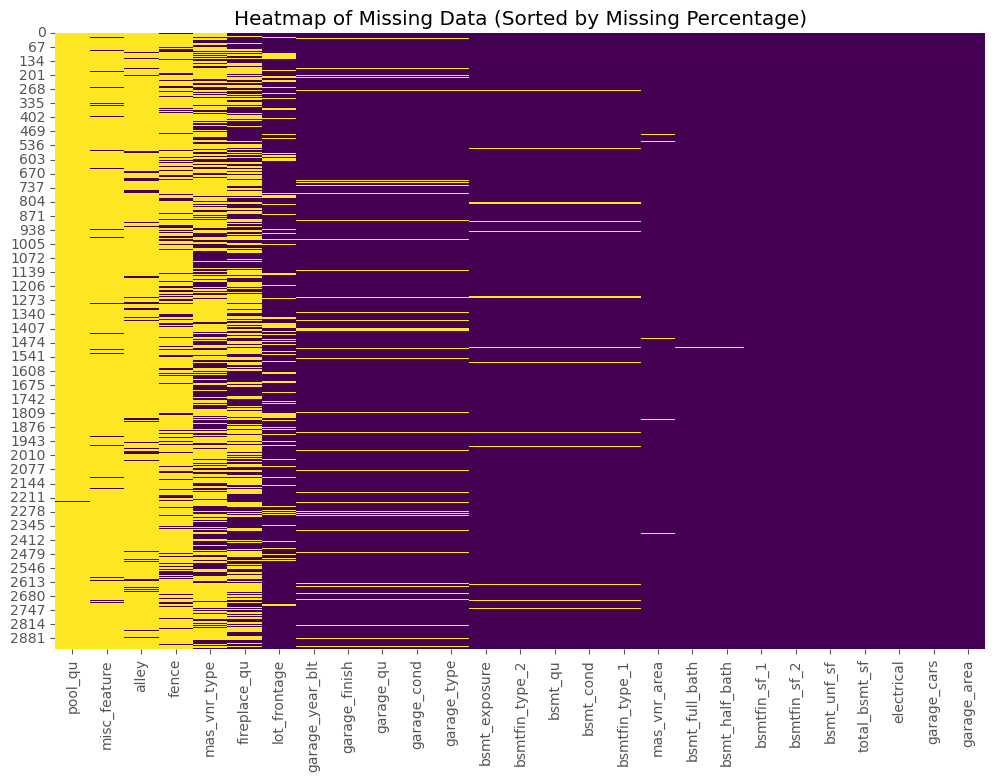

In [33]:
# Call the function to plot the heatmap
plot_missing_data_heatmap(df)

## Pool, Basement, Fireplace, Fence, Alley, Misc Features, Garage

Firstly, from the data dictionary, we know that 'NA' would imply No Pools! In fact, we can check this with the pool area.  

In [34]:
# Assert whether all pool_area values are 0 for missing pool_qu
assert (df[df['pool_qu'].isnull()]['pool_area'] == 0).all(), "Not all missing pool_qu have pool_area equal to 0"


In the dataset, missing values for variables such as `bsmt` (basement-related features) are represented by `NA`, indicating the absence of a basement. Similarly, `NA` values in variables like `fence`, `garage`, `fireplace`, `alley` denote the absence of these respective features (e.g., no fence, no garage, no fireplace, and no alley access). Additionally, `NA` in the `misc_feature` variable signifies that no miscellaneous features are recorded for those entries. Then, the numerical features of corresponding areas are also missing and we will fill them in with 0. 

### Electrical

There is only one missing value for electrical. 

In [36]:
df[df['electrical'].isnull()][['ms_subclass', 'neighborhood', 'year_blt', 'street']]

,ms_subclass,neighborhood,year_blt,street
1577,80,Timber,2006,Pave


In [37]:
# Check for the type similar properties in the area as they tend to have the same electrical type
df[(df['ms_subclass'] == 80) & (df['neighborhood'] == "Timber")].groupby(['street', 'year_blt'])['electrical'].value_counts().unstack(fill_value=0)

electrical       SBrkr
street year_blt       
Pave   1987          1
       1988          1
       2003          1
       2006          1

All the buildings in the paved road access and `ms_subclass` (building class) and this Timber neighborhood all have SBrkr (Standard Circuit Breakers & Romex) as the electrical type. Therefore, it is reasonable to impute this missing value with SBrkr. 

### Masonry veneer type and area

In [40]:
# Call the function and print the results for 'mas_vnr_area' and 'mas_vnr_type'
percentages = consistency_missing_type_area(df, 'mas_vnr_area', 'mas_vnr_type')
print(f"Percentage of missing 'mas_vnr_type' where 'mas_vnr_area' is 0: {percentages['percent_missing_area_zero']:.2f}%")
print(f"Percentage of missing 'mas_vnr_type' where 'mas_vnr_area' is missing: {percentages['percent_missing_area_missing']:.2f}%")
print(f"Percentage of missing 'mas_vnr_type' where 'mas_vnr_area' has other values: {percentages['percent_missing_area_other']:.2f}%")


Percentage of missing 'mas_vnr_type' where 'mas_vnr_area' is 0: 98.31%
Percentage of missing 'mas_vnr_type' where 'mas_vnr_area' is missing: 1.30%
Percentage of missing 'mas_vnr_type' where 'mas_vnr_area' has other values: 0.39%


Interestingly, for most where `mas_vnr_type` is missing, we observe that its area is 0. There is very small proportion where the area takes some other values. We will then impute all the missing `mas_vnr_type` with 'NA' and `mas_vnr_area` with 0. This can be done by simply adding '
'mas_vnr' to the keywords when calling ``simple_fill_missing_by_keywords()``

### Garage Year Inconsistency

Now, check for inconsistencies in the year built and year sold if any houses are sold before they are built or fully remodelled. Furthermore, we check if any values are out of the range of the dataset 2006-2010. 

In [39]:
report_inconsistent_years(df, ['year_blt','year_remod/add' ,'garage_year_blt'], 'year_sold')

,year_blt,year_remod/add,garage_year_blt,year_sold
2180,2008,2009,2008,2007
1702,2007,2008,2007,2007
2260,2006,2007,2207,2007


There is one observation that is built and one that is remodeled after it is sold. Additionally, there seems to be a typo for index 2260 in its `garage_year_blt`. However, it seems like the garage was build with remodelled and it was a typo from 2007 to 2207.

### Lot Frontage

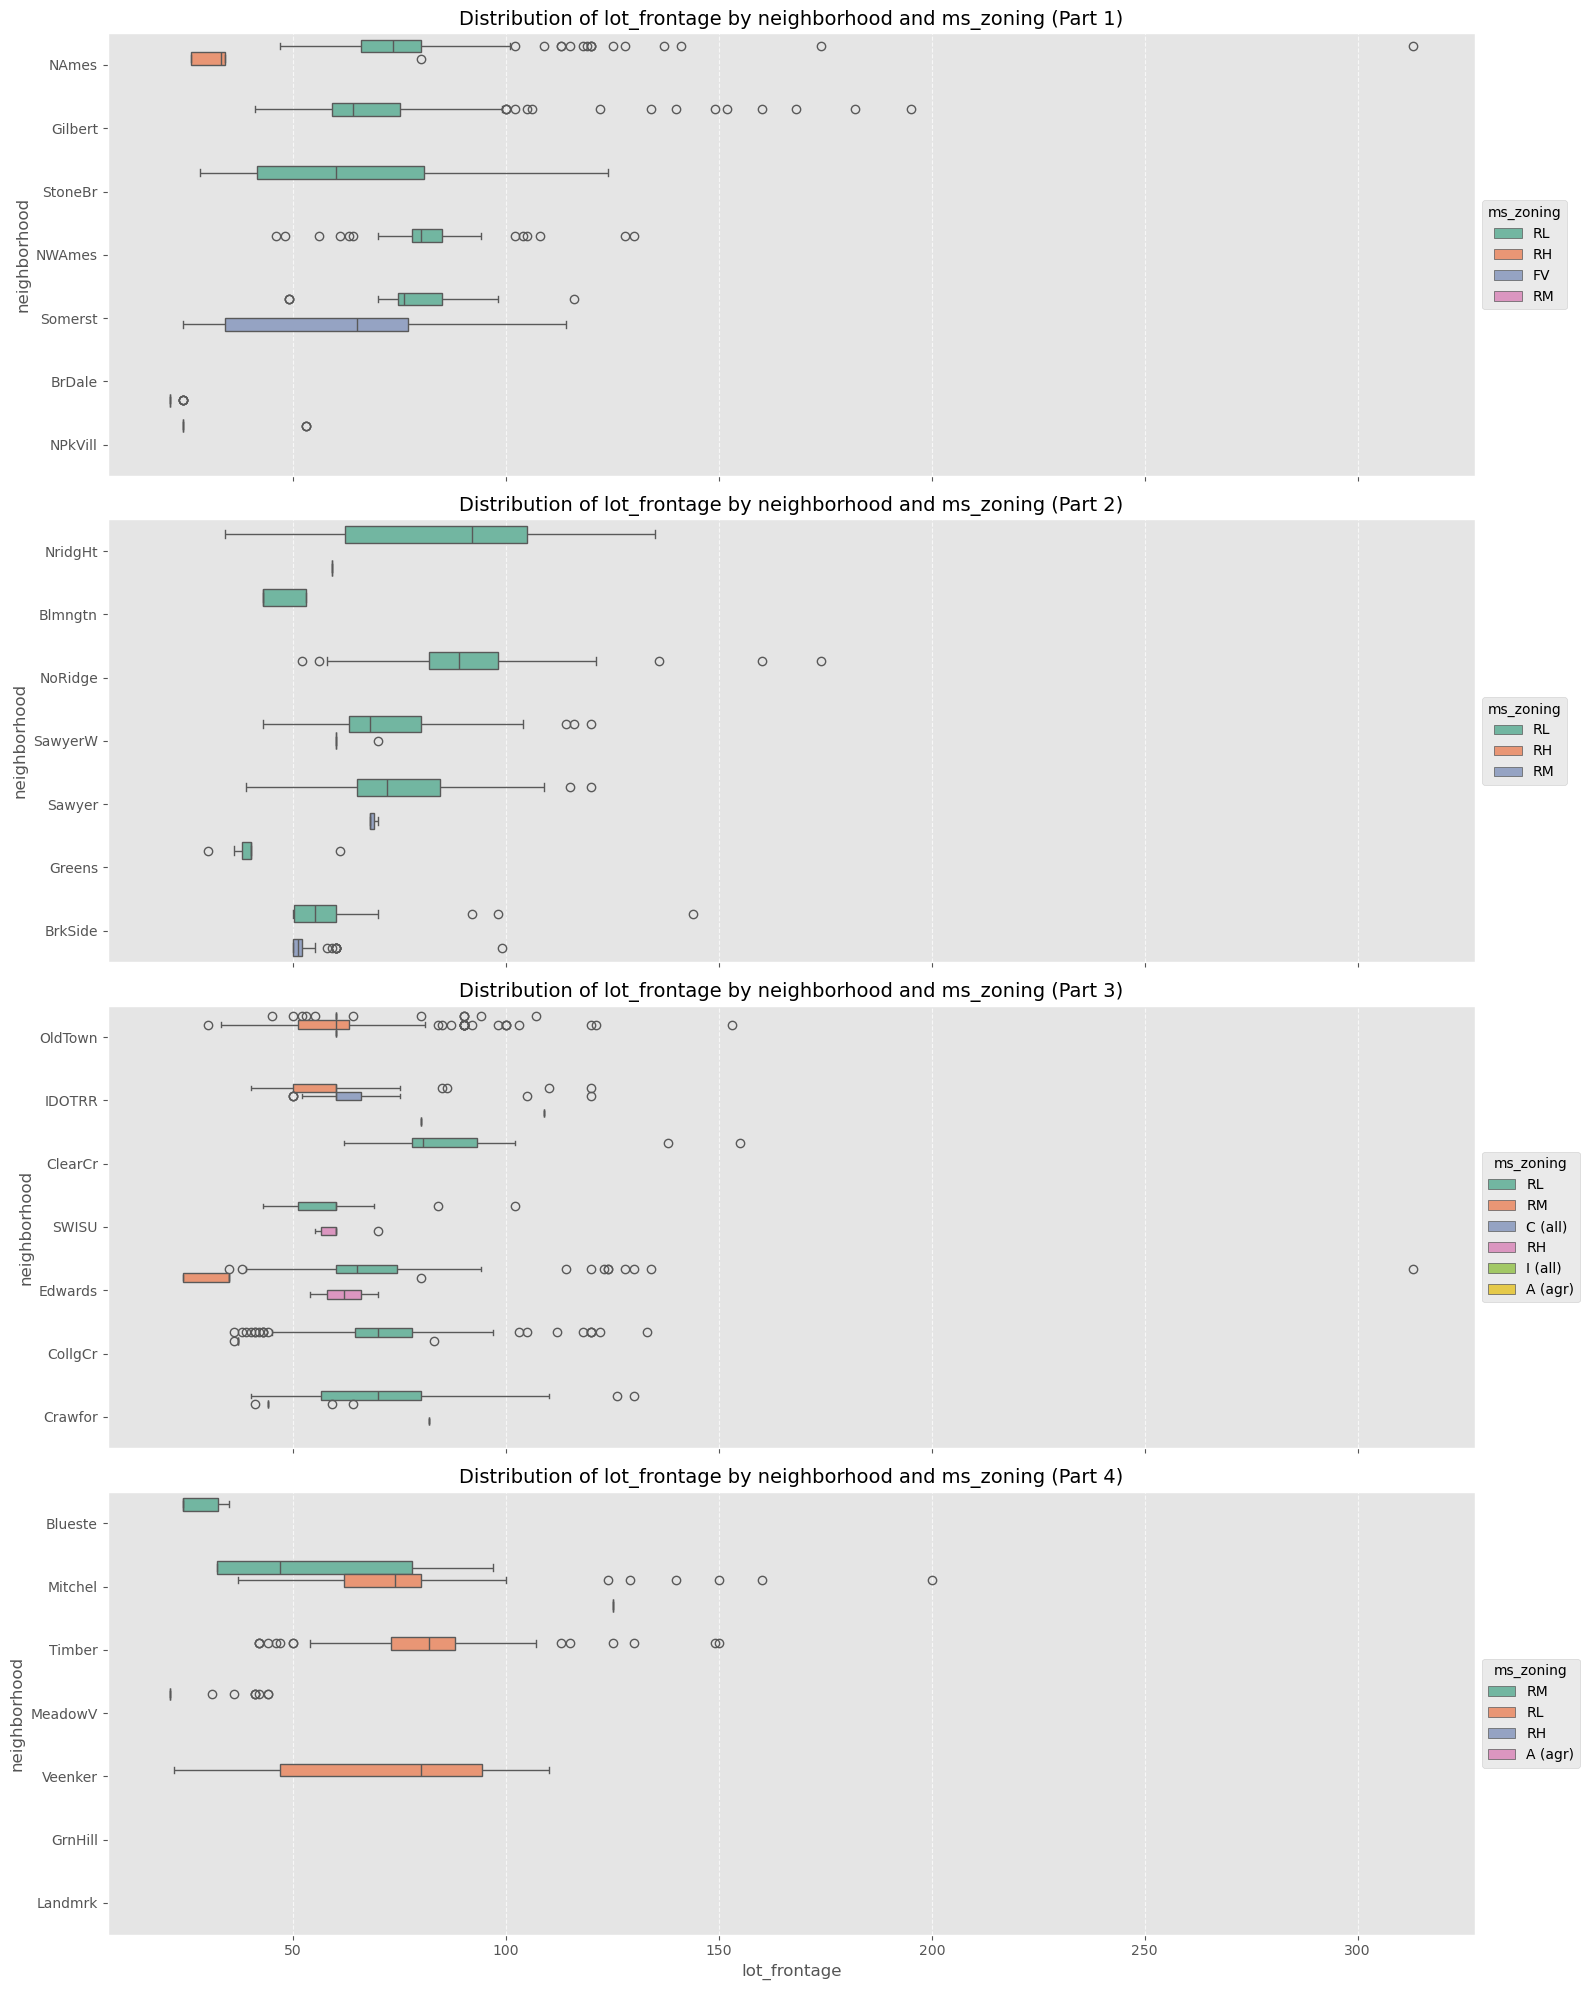

In [44]:
# Example usage
box_plot_dist(df, x='lot_frontage', y='neighborhood', hue='ms_zoning')

This shows that although there are some outliers based on the `lot_frontage` and `neighborhood`, it is not too bad in the sense that unless it is for the ms_zoning RM, RL (resiential areas with low to medium density) or FV (floating village residential), the distribution of `lot_frontage` is very concentrated. And even for those cases, the discrepancy are within 100 feet. We will then impute the missing values with the median of the `lot_frontage` of observations with the same `neighborhood` and `ms_zoning`. 

# Some EDAs on the Outcome Variable: Sale Price

Price Range:
- Minimum: $12,789
- Maximum: $755,000

Key Statistics:
- Mean: $180,796
- Median: $160,000
- Standard Deviation: $79,887

Price Range Distribution (%):
saleprice
<$100k          8.6
$100k-$200k    62.2
$200k-$300k    21.4
$300k-$400k     5.7
>$400k          2.2


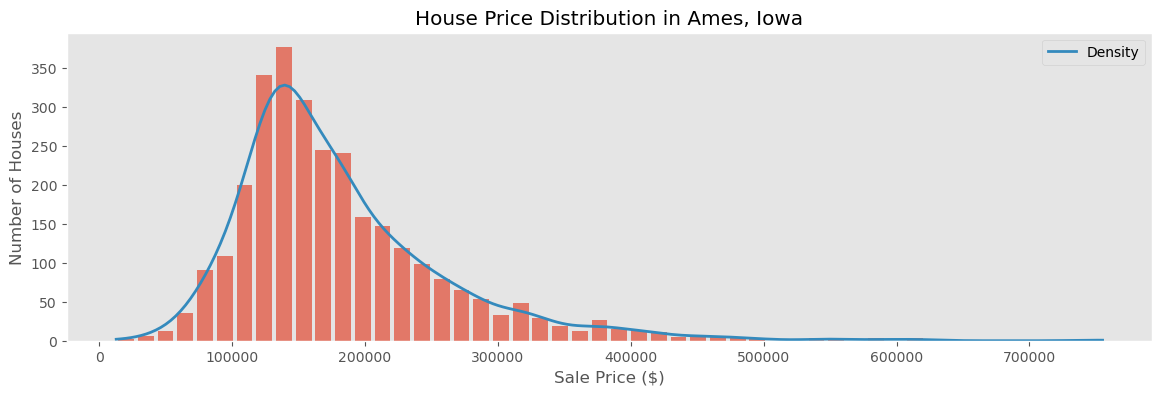

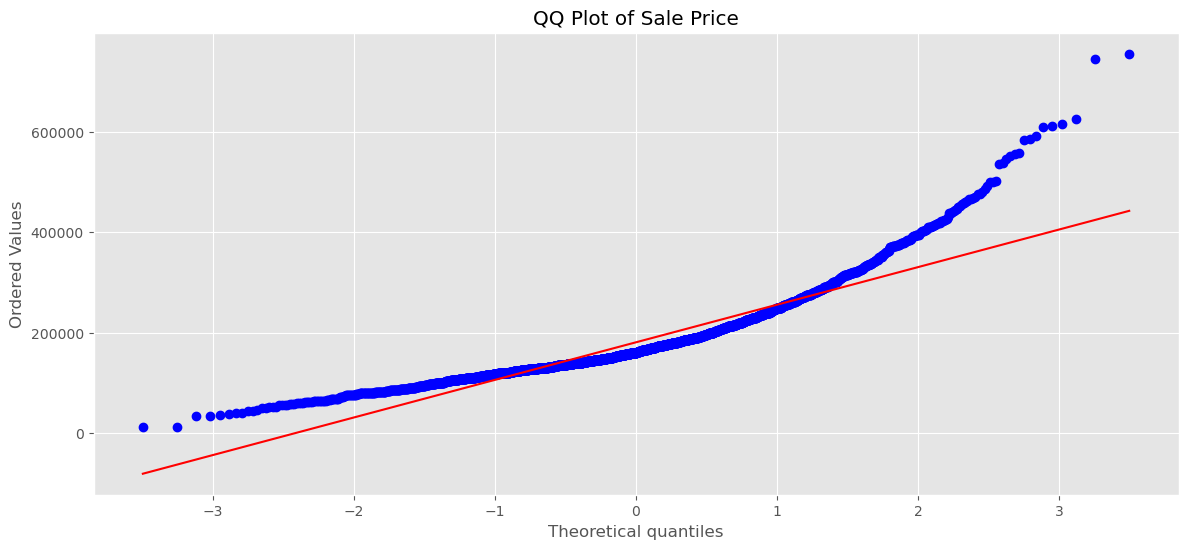

Normality test result:
Statistic: 1074.65, p-value: 4.40e-234

Shapiro-Wilk test result:
Statistic: 0.88, p-value: 2.33e-43

Anderson-Darling test result:
Statistic: 87.37
Significance level 15.0%: Critical value 0.57, Reject the null hypothesis
Significance level 10.0%: Critical value 0.66, Reject the null hypothesis
Significance level 5.0%: Critical value 0.79, Reject the null hypothesis
Significance level 2.5%: Critical value 0.92, Reject the null hypothesis
Significance level 1.0%: Critical value 1.09, Reject the null hypothesis

Kurtosis test result:
Kurtosis: 8.11

Jarque-Bera test result:
Statistic: 4668.42, p-value: 0.00e+00


In [54]:
# Analyze house price distribution
print('Price Range:')
print('- Minimum: ${:,.0f}'.format(df['saleprice'].min()))
print('- Maximum: ${:,.0f}'.format(df['saleprice'].max()))
print('\nKey Statistics:')
print('- Mean: ${:,.0f}'.format(df['saleprice'].mean()))
print('- Median: ${:,.0f}'.format(df['saleprice'].median()))
print('- Standard Deviation: ${:,.0f}'.format(df['saleprice'].std()))

# Show price range distribution
price_ranges = pd.cut(df['saleprice'], 
                     bins=[0, 100000, 200000, 300000, 400000, float('inf')],
                     labels=['<$100k', '$100k-$200k', '$200k-$300k', '$300k-$400k', '>$400k'])
print('\nPrice Range Distribution (%):')
print(price_ranges.value_counts(normalize=True).mul(100).round(1).sort_index().to_string())

# Create histogram with density curve
plt.figure(figsize=(14,4))
plt.hist(df['saleprice'], bins=50, rwidth=.8, alpha=0.7)
density = gaussian_kde(df['saleprice'])
xs = np.linspace(df['saleprice'].min(), df['saleprice'].max(), 200)
density_scaled = density(xs) * len(df['saleprice']) * (df['saleprice'].max() - df['saleprice'].min())/50
plt.plot(xs, density_scaled, linewidth=2, label='Density')
plt.title('House Price Distribution in Ames, Iowa')
plt.xlabel('Sale Price ($)')
plt.ylabel('Number of Houses')
plt.legend()
plt.grid(False)
plt.show()

import scipy.stats as stats

# QQ plot to check normality
plt.figure(figsize=(14, 6))
stats.probplot(df['saleprice'], dist="norm", plot=plt)
plt.title('QQ Plot of Sale Price')
plt.show()

# Perform normality tests
k2, p = stats.normaltest(df['saleprice'])
print("Normality test result:")
print(f"Statistic: {k2:.2f}, p-value: {p:.2e}")

# Shapiro-Wilk test
stat, p = stats.shapiro(df['saleprice'])
print("\nShapiro-Wilk test result:")
print(f"Statistic: {stat:.2f}, p-value: {p:.2e}")

# Anderson-Darling test
result = stats.anderson(df['saleprice'])
print("\nAnderson-Darling test result:")
print(f"Statistic: {result.statistic:.2f}")
for i, (cv, sig) in enumerate(zip(result.critical_values, result.significance_level)):
    print(f"Significance level {sig}%: Critical value {cv:.2f}, {'Reject' if result.statistic > cv else 'Fail to reject'} the null hypothesis")

# Perform fat-tailed test (Kurtosis test) on the sale price distribution
kurtosis = stats.kurtosis(df['saleprice'], fisher=False)
print("\nKurtosis test result:")
print(f"Kurtosis: {kurtosis:.2f}")

# Perform Jarque-Bera test
jb_stat, jb_p = stats.jarque_bera(df['saleprice'])
print("\nJarque-Bera test result:")
print(f"Statistic: {jb_stat:.2f}, p-value: {jb_p:.2e}")


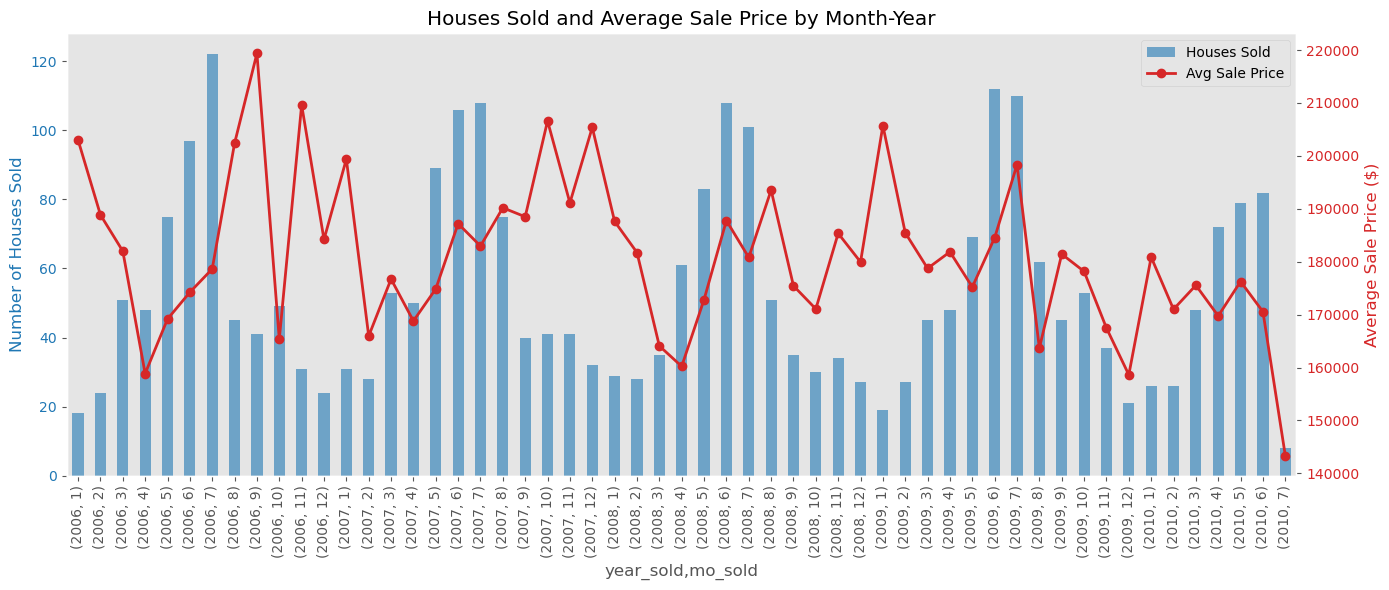

In [50]:
# The correct column names are likely 'yr_sold' and 'mo_sold'
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the count of houses sold
color = 'tab:blue'
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Number of Houses Sold', color=color)
house_count = df.groupby(['year_sold', 'mo_sold']).pid.count()
house_count.plot(kind='bar', ax=ax1, color=color, alpha=0.6, label='Houses Sold')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the average sale price
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Sale Price ($)', color=color)
avg_price = df.groupby(['year_sold', 'mo_sold']).saleprice.mean()
avg_price.plot(ax=ax2, color=color, marker='o', linestyle='-', linewidth=2, label='Avg Sale Price')
ax2.tick_params(axis='y', labelcolor=color)

# Add titles and legends
plt.title('Houses Sold and Average Sale Price by Month-Year')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Remove grid
ax1.grid(False)
ax2.grid(False)

plt.show()

# Correct the data format

### Feature Classification

#### Building Class:
- **`ms_subclass`**: Represents the class of the building and serves as a categorical variable.

#### Quality and Condition Rankings:
- **`overall_qual`**: Overall quality of the house.
- **`overall_cond`**: Overall condition of the house.

#### Bathroom Counts:
- **`bsmt_full_bath`**, **`bsmt_half_bath`**, **`full_bath`**, **`half_bath`**: Indicate the number of bathrooms. A higher number generally suggests a higher property value.

#### Room Counts:
- **`bedroom_abv_gr`**: Number of bedrooms above grade.
- **`kitchen_abv_gr`**: Number of kitchens above grade.
- **`totrms_abvgrd`**: Total rooms above grade (excluding bathrooms).
- **`fireplaces`**: Number of fireplaces. More rooms or features often correlate with higher value.

#### Other Discrete Features:
- **`garage_cars`**: Garage capacity (5 unique values).
- **`pool_area`**: Most are zero (maybe just no pools or there can be some problems with the data recording). Only 13 houses have positive pool size. Looking into this online, it seems like the data may actually miss information about the pool, and record 0 for all houses in such cases, some of they may still have pools actually.
- **`mo_sold`**, **`yr_sold`**: Represent the sale month and year, which can potentially be combined into a single "month-year sold" feature, and maybe compare 'yr_sold' to 'yr_built' to see if the house is old or new, instead of keeping them as numerical variables on their own, while preserving the same information. 

In [358]:
# Convert to category
df[['ms_subclass', 'overall_qual', 'overall_cond']] = df[['ms_subclass', 'overall_qual', 'overall_cond']].astype('category')

In [359]:
# Create train/test split
df = create_sample_split(df, "pid")

# Display split information  
print("\nSplit sizes:")
print(df['sample'].value_counts())
print("\nSplit proportions:") 
print(df['sample'].value_counts(normalize=True))



Split sizes:
sample
train    2448
test      482
Name: count, dtype: int64

Split proportions:
sample
train    0.835495
test     0.164505
Name: proportion, dtype: float64


In [360]:
# Split data into train and test sets based on sample column
train = df[df['sample'] == 'train'].copy()
test = df[df['sample'] == 'test'].copy()

print("Training set shape:", train.shape)
print("Test set shape:", test.shape)


Training set shape: (2448, 83)
Test set shape: (482, 83)


In [361]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 2448 entries, 0 to 2929
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   order            2448 non-null   int64   
 1   pid              2448 non-null   int64   
 2   ms_subclass      2448 non-null   category
 3   ms_zoning        2448 non-null   object  
 4   lot_frontage     2037 non-null   float64 
 5   lot_area         2448 non-null   int64   
 6   street           2448 non-null   object  
 7   alley            2448 non-null   object  
 8   lot_shape        2448 non-null   object  
 9   land_contour     2448 non-null   object  
 10  utilities        2448 non-null   object  
 11  lot_config       2448 non-null   object  
 12  land_slope       2448 non-null   object  
 13  neighborhood     2448 non-null   object  
 14  condition_1      2448 non-null   object  
 15  condition_2      2448 non-null   object  
 16  bldg_type        2448 non-null   object  
 17  